In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Colaboratory/House Prices Kaggle/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colaboratory/House Prices Kaggle


In [2]:
%matplotlib inline
%pylab inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
from google.colab import data_table
data_table.enable_dataframe_formatter()




Populating the interactive namespace from numpy and matplotlib


## Load data


In [3]:

# -- Setting max display for pandas
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('DATA/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('DATA/house-prices-advanced-regression-techniques/test.csv')
# train = train[0:20]

# pd.set_option('display.max_columns', None)

# Here we can seperate the qualative and quantative data by checking if the 
# datatypes are object or not
quant = [f for f in train.columns if train.dtypes[f] != 'object']
quant.remove('SalePrice')
quant.remove('Id')

qual = [f for f in train.columns if train.dtypes[f] == 'object']

for col in train.columns:
    print(col)

Id
MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
PoolQC
Fence
MiscFeature
MiscVal
MoSold
YrSold
SaleType
SaleCondition
SalePrice


## Checking Data


In [4]:
# Check for duplicates

unique = len(set(train.Id))
total = train.shape[0]
duplicates = total - unique
print(f"there are {str(duplicates)} duplicated ID's for {str(total)} total entries")

# Drop Id column
train.drop("Id", axis = 1, inplace = True)



there are 0 duplicated ID's for 1460 total entries


## Scatter plot to compare vairables

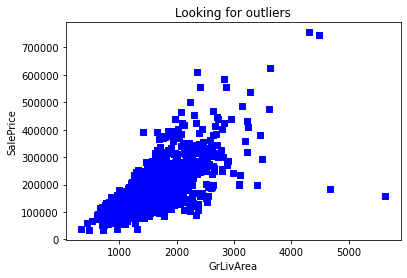

In [5]:
# 
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

# X = X[X.GrLivArea < 4000]

# Missing values 

the NAN take up a lot of the data, this is usually due to factors that are missing in the property analysis eg missing pool or fence


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


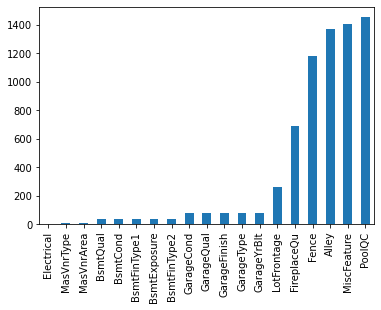

In [6]:
# This combination of isnull.sum shows all columns that contain null values
# and the sum of the null values in that column
missing = train.isnull().sum()


# Removing all 0 values to make a new pd series
missing = missing[missing > 0]
print(missing)
# Bar plot of missing values
missing.sort_values(inplace=True)
missing.plot.bar()


In [7]:

# Easy function for displaying value counts
def exploration(df, column):
    return df[column].value_counts()

def nans(df, column):
  return df[column].isna().sum()

# Easy function for replacing nan values
def imputation(df, column, value = 'NA'):
    df.loc[df[column].isnull(),column] = value


List of all the features containing NANS:

LotFrontage, Alley, MasVnrType, MasVnrArea, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu, GarageType, GarageYrBlt,     GarageFinish, GarageQual, GarageCond, PoolQC, Fence,      MiscFeature     

 Lot Frontage and Area Correlation Value: 0.42609501877180833

 Lot Frontage and Sqrt of Area Correlation Value: 0.6020022167939361



Text(0.5, 0.98, 'Frontage/Sqrt Area')

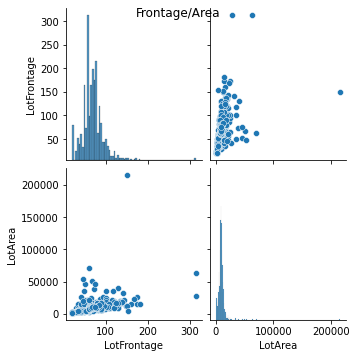

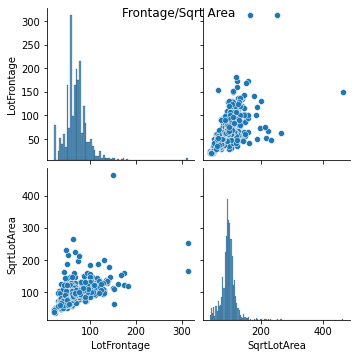

In [8]:
# checking for Frontage correlation with Area
front_area = train['LotFrontage'].corr(train['LotArea'])
print(f" Lot Frontage and Area Correlation Value: {front_area}\n")

# Creating a new column for Sqrt Lot Area - # This is taking the VERY general
# assumption that all lots are square - this is also assuming that all lots have 
# frontage
train['SqrtLotArea']=np.sqrt(train['LotArea'])

# Checking for a correlation between the two
front_sqr_area = train['LotFrontage'].corr(train['SqrtLotArea'])
print(f" Lot Frontage and Sqrt of Area Correlation Value: {front_sqr_area}\n")

lf = sns.pairplot(train[['LotFrontage','LotArea']].dropna())
lf.fig.suptitle('Frontage/Area')

lf = sns.pairplot(train[['LotFrontage','SqrtLotArea']].dropna())
lf.fig.suptitle('Frontage/Sqrt Area')


In [9]:
# Replacing the lot frontage null values with the square root of the lot area. 
nulls = train['LotFrontage'].isnull()
train.LotFrontage[nulls]=train.SqrtLotArea[nulls]
del train['SqrtLotArea']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Alley

In [10]:
# Weighting
feature = "Alley"
print(f"Value Counts of {feature}: \n{exploration(train,'Alley')}\n")
print(f"Amount of Nans in {feature}: \n{nans(train,'Alley')}")

# Assuming that these properties do not contain an alley
imputation(train,'Alley','None')

Value Counts of Alley: 
Grvl    50
Pave    41
Name: Alley, dtype: int64

Amount of Nans in Alley: 
1369


MasVnr Type and Area

In [11]:
feature = "MasVnr Type and Area"
print(f"Amount of Nans in {feature}: \n{nans(train,['MasVnrType','MasVnrArea'])}")

# The null values are for the same indexes/properties
# Type is a string and area is float
print("\nNull Values are the same properties:")
print(train[['MasVnrType','MasVnrArea']][train['MasVnrType'].isnull()==True])

imputation(train,'MasVnrType', 'None')
imputation(train,'MasVnrArea', 0.0)

print(f"Checking for any more NANS: \nAmount of Nans in {feature}: \n{nans(train,['MasVnrType','MasVnrArea'])}\n")


Amount of Nans in MasVnr Type and Area: 
MasVnrType    8
MasVnrArea    8
dtype: int64

Null Values are the same properties:
     MasVnrType  MasVnrArea
234         NaN         NaN
529         NaN         NaN
650         NaN         NaN
936         NaN         NaN
973         NaN         NaN
977         NaN         NaN
1243        NaN         NaN
1278        NaN         NaN
Checking for any more NANS: 
Amount of Nans in MasVnr Type and Area: 
MasVnrType    0
MasVnrArea    0
dtype: int64



Basement Values


In [12]:
feature = "basement features"
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

print("\nBasement Null Values:")
train[basement_cols][train['BsmtQual'].isnull()==True]


Basement Null Values:


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2
17,NaN,NaN,NaN,NaN,NaN,0,0
39,NaN,NaN,NaN,NaN,NaN,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0
102,NaN,NaN,NaN,NaN,NaN,0,0
156,NaN,NaN,NaN,NaN,NaN,0,0
182,NaN,NaN,NaN,NaN,NaN,0,0
259,NaN,NaN,NaN,NaN,NaN,0,0
342,NaN,NaN,NaN,NaN,NaN,0,0
362,NaN,NaN,NaN,NaN,NaN,0,0
371,NaN,NaN,NaN,NaN,NaN,0,0


In [13]:
# Repacing the NaN as the zeros are fine here, 
# so assigning in this function bymuissing the alst two cols

for cols in basement_cols:
    if 'BsmtFinSF'not in cols:
        imputation(train, cols,'None')


Electrical

In [14]:
print(exploration(train, 'Electrical'))
print(nans(train,'Electrical'))

# only one value missing so the most common value is imputed
imputation(train, 'Electrical', 'SBrkr')

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
1


Fireplace

In [15]:
# Comparing the mising values of fireplace quality with amount of fire place

print(f"{exploration(train,'FireplaceQu')}")
print(f"\n{exploration(train,'Fireplaces')}")
print(f"\n{train['Fireplaces'][train['FireplaceQu'].isnull()==True].describe()}")

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

count    690.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Fireplaces, dtype: float64


In [16]:
imputation(train,'FireplaceQu','None')

In [17]:
# Cross tabulating the two columns
pd.crosstab(train.Fireplaces, train.FireplaceQu)

FireplaceQu,Ex,Fa,Gd,None,Po,TA
Fireplaces,,,,,,
0,0,0,0,690,0,0
1,19,28,324,0,20,259
2,4,4,54,0,0,53
3,1,1,2,0,0,1


Garages

In [18]:
# Same proccess as in basedment features
garage_cols=['GarageType','GarageQual','GarageCond','GarageFinish','GarageCars','GarageArea']
train[garage_cols][train['GarageType'].isnull()==True]

imputation(train, 'GarageYrBlt', train['YearBuilt'])

In [19]:
for cols in garage_cols:
    if train[cols].dtype==np.object:
        imputation(train, cols,'None')
    else:
        imputation(train, cols, 0)

pool

In [20]:
# Following same proccess as fireplaces
print(exploration(train, 'PoolQC'))
print(train['PoolArea'][train['PoolQC'].isnull()==True].describe())

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64
count    1453.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: PoolArea, dtype: float64


In [21]:
# Many properties dont have a pool so we can just impute the data
imputation(train,'PoolQC', 'None')

Fence

In [22]:
imputation(train, 'Fence', 'None')

Misc

In [23]:
imputation(train, 'MiscFeature', 'None')

In [24]:
# add a new feature 'total sqfootage'
# checking for Frontage correlation with Area
area = train['TotalBsmtSF'].corr(train['1stFlrSF'])
print(f" BSMT + First Floor Correlation Value: {area}\n")

area = train['TotalBsmtSF'].corr(train['2ndFlrSF'])
print(f" BSMT + Second Floor Correlation Value: {area}\n")

area = train['2ndFlrSF'].corr(train['1stFlrSF'])
print(f" 1st + Second Floor Correlation Value: {area}\n")


train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
print('There are currently ' + str(train.shape[1]) + ' columns.')

 BSMT + First Floor Correlation Value: 0.8195299750050337

 BSMT + Second Floor Correlation Value: -0.17451195013496051

 1st + Second Floor Correlation Value: -0.202646181002321



NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


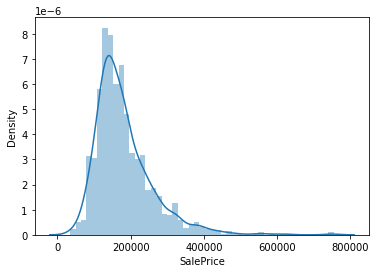

In [26]:

ax = sns.distplot(train['SalePrice'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


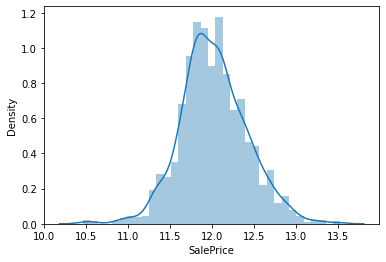

In [28]:
# log-transform the dependent variable for normality
salesprice_log = np.log(train['SalePrice'])

ax = sns.distplot(salesprice_log)
plt.show()